In [1]:
# Data Processing - Movie Lens
import pandas as pd
from itertools import islice
import seaborn as sns
import matplotlib.pyplot as plt

In [183]:
columns = ['movie_id', 'title', 'release_date', 'video_release_date', 
          'imdb_url'] + [f'genre_{i}' for i in range(19)]  # for the 19 binary columns

df = pd.read_csv('../data/ml-100k/u.item', 
                 delimiter='|', encoding='latin-1',
                names=columns)
# save movie titles
df['title'].to_csv('100k_titles.csv')

In [184]:
# predict user viewership by month

In [2]:
ratings_df = pd.read_csv('../data/ml-100k/u.data', 
                 delimiter='\t', encoding='latin-1',
                names=["user-id", "item-id", "rating", "timestamp"])

In [4]:
user_df = pd.read_csv('../data/ml-100k/u.user', 
                 delimiter='|', encoding='latin-1',
                names=["user-id", "age", "gender", "occupation", "zip"])

In [42]:
n = len(user_df)
monthly_user_dict = {}
for name, u_df in islice(ratings_df.groupby('user-id'), n): 
    time_stamps = u_df.sort_values('timestamp')['timestamp']
    dt_index = pd.to_datetime(u_df['timestamp'], unit='s')
    monthly_counts = u_df.groupby(dt_index.dt.to_period('M')).size()
    if len(monthly_counts) > 1: 
        monthly_user_dict[name] = monthly_counts

In [43]:
len(monthly_user_dict)

228

In [44]:
def create_user_features(user_df, monthly_user_dict):
    """
    Create features for users based on their movie watching history.
    Total movies is cumulative, increasing each month.
    
    Args:
        user_df (pd.DataFrame): DataFrame containing user information
        monthly_user_dict (dict): Dictionary with monthly movie counts per user
        
    Returns:
        pd.DataFrame: containing user features
    """
    new_features = [] 
    for _, row in user_df.iterrows(): 
        if row['user-id'] in monthly_user_dict: 
            monthly_counts = monthly_user_dict[row['user-id']].values
            total_movies = 0 
            
            for i, monthly_count in enumerate(monthly_counts): 
                total_movies += int(monthly_count)
                if i >0: 
                    new_features.append({
                        'user-id': row['user-id'], 
                        'age': int(row['age']),
                        'gender': row['gender'],
                        'occupation': row['occupation'], 
                        'zip': row['zip'], 
                        'movies_watched': total_movies, 
                        'movies_this_month': int(monthly_count), 
                    })
    return pd.DataFrame(new_features)

In [45]:
dataset = create_user_features(user_df, monthly_user_dict)

In [46]:
dataset

,user-id,age,gender,occupation,zip,movies_watched,movies_this_month
0,1,24,M,technician,85711,172,47
1,1,24,M,technician,85711,251,79
2,1,24,M,technician,85711,253,2
3,1,24,M,technician,85711,261,8
4,1,24,M,technician,85711,272,11
...,...,...,...,...,...,...,...
537,921,20,F,student,98801,110,28
538,924,29,M,other,11753,76,28
539,924,29,M,other,11753,82,6
540,940,32,M,administrator,02215,107,5


In [47]:
dataset.to_csv('clean_data/movie_lens100k_monthly.csv')

In [48]:
b = 20
y = dataset['movies_this_month'] > b
X = dataset[['age', 'gender', 'occupation', 'zip', 'movies_watched']]

Text(0.5, 1.0, 'number of movies per month')

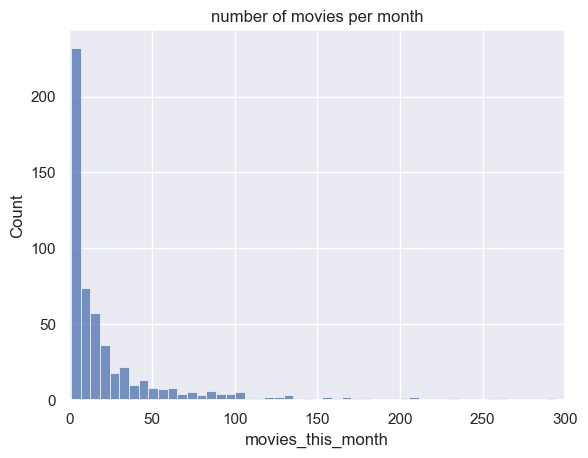

In [58]:
sns.histplot(dataset['movies_this_month'])
plt.xlim(0, 300)
plt.title("number of movies per month")

Text(0.5, 1.0, 'number of movies per month')

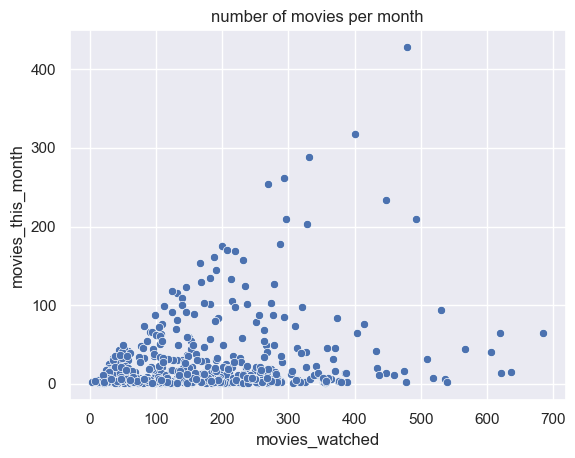

In [60]:
sns.scatterplot(x=dataset['movies_watched'], y=dataset['movies_this_month'])
#plt.xlim(0, 300)
plt.title("number of movies per month")

Text(0.5, 1.0, 'number of movies per month')

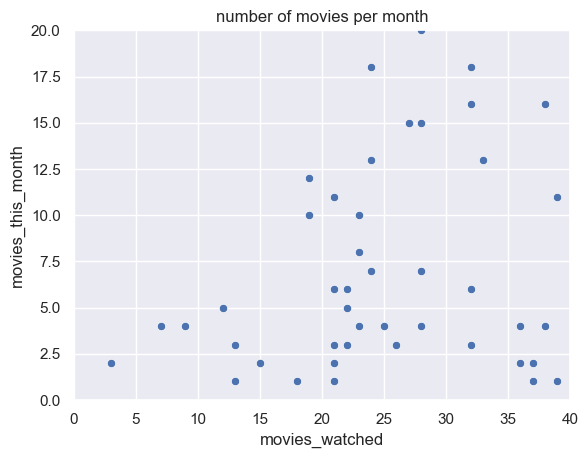

In [64]:
sns.scatterplot(x=dataset['movies_watched'], y=dataset['movies_this_month'])
plt.ylim(0, 20)
plt.xlim(0, 40)
plt.title("number of movies per month")

In [49]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn import tree

In [54]:
vec = DictVectorizer()
X_post = vec.fit_transform(X.to_dict('records')).toarray()

results = [] 
num_runs = 5
for i in range(num_runs): 
    for b in [3, 5, 10, 15, 20, 30]: 
        y = dataset['movies_this_month'] > b
        X_train, X_test, y_train, y_test = train_test_split(
            X_post, y, test_size=0.33, random_state=i)

        clf_rf = RandomForestClassifier(max_depth=4, random_state=0)
        clf_rf.fit(X_train, y_train)

        results.append({
            'clf': 'Random Forest', 
            'run': i, 
            'b': b, 
            'accuracy': clf_rf.score(X_test, y_test), 
            'auc': roc_auc_score(y_test, clf_rf.predict_proba(X_test)[:, 1])
        })

        clf_dt = tree.DecisionTreeClassifier()
        clf_dt.fit(X_train, y_train)
        clf_dt.predict(X_test)
        results.append({
            'clf': 'Decision Tree', 
            'run': i, 
            'b': b, 
            'accuracy': clf_dt.score(X_test, y_test), 
            'auc': roc_auc_score(y_test, clf_dt.predict_proba(X_test)[:, 1])
        })

Text(0.5, 0, 'Prediction Threshold (Cost to Buy - b)')

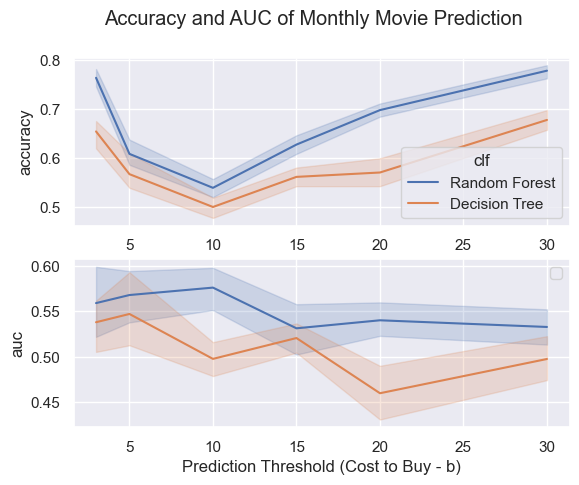

In [55]:
sns.set_theme()
plot_df = pd.DataFrame(results)
fig, axes = plt.subplots(2, 1)
axes = axes.flatten()
sns.lineplot(data=plot_df, hue='clf', x='b', y='accuracy', ax=axes[0])
sns.lineplot(data=plot_df, hue='clf', x='b', y='auc', ax=axes[1])
axes[1].legend([])
plt.suptitle("Accuracy and AUC of Monthly Movie Prediction")
plt.xlabel("Prediction Threshold (Cost to Buy - b)")